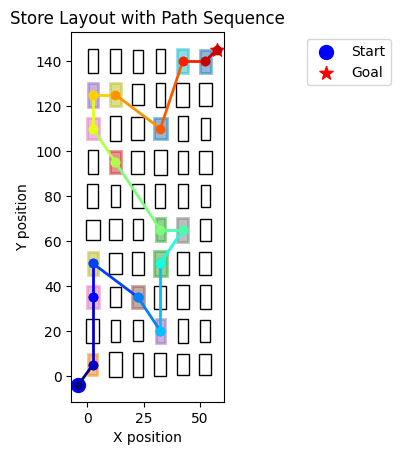

In [1]:
import numpy as np
from scipy.spatial import distance
from store import Store
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def compute_euclidean_distance_matrix(locations):
    return distance.cdist(locations, locations, "euclidean").astype(int)


def plot_store(store, random_shelves, path):
    fig, ax = plt.subplots()
    tab20 = plt.get_cmap("tab20")  # Using 'tab20' colormap for shelves
    tab10 = plt.get_cmap("tab10")  # Using 'tab10' colormap for shelves
    jet = plt.get_cmap("jet")  # For  path

    all_shelves_coords = np.array(
        [(shelf.cx, shelf.cy) for row in store.shelves for shelf in row]
    )

    for i, row in enumerate(store.shelves):
        for shelf in row:
            # Default shelf appearance
            color = "black"
            fill = "none"
            linewidth = 1
            alpha = 1

            if shelf in random_shelves:
                color_index = random_shelves.index(shelf)
                color = tab10(color_index / len(random_shelves))
                fill = color
                linewidth = 2
                alpha = 0.5

            rect = patches.Rectangle(
                (shelf.cx - shelf.width / 2, shelf.cy - shelf.length / 2),
                shelf.width,
                shelf.length,
                linewidth=linewidth,
                edgecolor=color,
                facecolor=fill,
                alpha=alpha,
            )
            ax.add_patch(rect)

    for i in range(len(path) - 1):
        start, end = path[i], path[i + 1]
        ax.plot(
            [start[0], end[0]],
            [start[1], end[1]],
            "o-",
            color=jet(i / (len(path) - 1)),
            linewidth=2,
        )

    start_point = path[0]
    goal_point = path[-1]
    ax.scatter(
        start_point[0], start_point[1], color="blue", s=100, marker="o", label="Start"
    )
    ax.scatter(
        goal_point[0], goal_point[1], color="red", s=100, marker="*", label="Goal"
    )

    ax.set_xlabel("X position")
    ax.set_ylabel("Y position")
    ax.set_title("Store Layout with Path Sequence")
    # ax.set_xlim(all_shelves_coords[:, 0].min() - 10, all_shelves_coords[:, 0].max() + 10)
    # ax.set_ylim(all_shelves_coords[:, 1].min() - 10, all_shelves_coords[:, 1].max() + 10)
    ax.set_aspect("equal")

    ax.legend(loc="upper left", bbox_to_anchor=(1.5, 1))

    plt.show()


def setup_routing_and_solve(data):
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )
    routing = pywrapcp.RoutingModel(manager)
    distance_matrix = compute_euclidean_distance_matrix(data["locations"])

    transit_callback_index = routing.RegisterTransitCallback(
        lambda from_index, to_index: distance_matrix[manager.IndexToNode(from_index)][
            manager.IndexToNode(to_index)
        ]
    )
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    routing.solver().Add(
        routing.NextVar(manager.NodeToIndex(len(data["locations"]) - 1))
        == routing.End(0)
    )

    # search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    # search_parameters.time_limit.seconds = 15
    # search_parameters.log_search = True

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Use GUIDED_LOCAL_SEARCH metaheuristic.
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
    )
    # Extend the search time limit for potentially deeper search.
    search_parameters.time_limit.seconds = 5
    # Use a more complex initial strategy to potentially get a better starting solution.
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
    )

    search_parameters.log_search = True

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        path = extract_path(manager, routing, solution, data["locations"])
        # print_solution(path, solution)
        return path
    else:
        print("No solution found!")
        return None


def extract_path(manager, routing, solution, locations):
    index = routing.Start(0)
    path = []
    while not routing.IsEnd(index):
        path.append(locations[manager.IndexToNode(index)])
        index = solution.Value(routing.NextVar(index))
    path.append(locations[manager.IndexToNode(index)])  # add the last point
    return np.array(path)[:-1]


def print_solution(path, solution):
    print(f"Objective: {solution.ObjectiveValue()}")
    route = " -> ".join(str(int(p)) for p in path)
    print(f"Route: {route}")


if __name__ == "__main__":
    k = 100

    store = Store(10, 6)
    start_location = np.array([-4, -4])
    random_shelves = store.get_random_shelves(15)
    selected_shelves_info = [
        (shelf.position, (shelf.cx, shelf.cy)) for shelf in random_shelves
    ]
    all_shelves_info = [
        (shelf.position, (shelf.cx, shelf.cy)) for row in store.shelves for shelf in row
    ]
    all_shelf_coords = np.array(
        [(shelf.cx, shelf.cy) for row in store.shelves for shelf in row]
    )
    furthest_shelf = all_shelf_coords[
        np.argmax(
            distance.cdist([start_location], all_shelf_coords, "euclidean").flatten()
        )
    ]
    goal_location = (furthest_shelf[0] + 5, furthest_shelf[1] + 5)
    selected_shelves_coords = np.array(
        [start_location]
        + [coords for _, coords in selected_shelves_info]
        + [goal_location]
    )
    locations = selected_shelves_coords * k
    data = {"locations": locations, "num_vehicles": 1, "depot": 0}
    path = setup_routing_and_solve(data)
    if path is not None:
        plot_store(
            store, random_shelves, path / 100
        )  # rescale coordinates for plotting